In [1]:
%matplotlib inline
import pandas as pd

<h4>Now, we have to initialize some variables that will be used. They will be used to collect the news titles, its categories, as well as a list of the different possible categories (without repetitions).</h4>

In [2]:
titles = [] # list of news titles
categories = [] # list of news categories
labels = [] # list of different categories (without repetitions)
nlabels = 4 # number of different categories
lnews = [] # list of dictionaries with two fields: one for the news and 
            # the other for its category


<h4>The code for this section will be organized in two functions: one which imports the data and the other which counts the news in each category, its percentage and plots it.</h4>

In [3]:
def import_data():
    global titles, labels, categories
    # importing news aggregator data via Pandas (Python Data Analysis Library)
    news = pd.read_csv(r"D:\Data science\Data sets\news-aggregator-dataset\uci-news-aggregator.csv")
    # function 'head' shows the first 5 items in a column (or
    # the first 5 rows in the DataFrame)
    print(news.head())
    categories = news['CATEGORY']
    titles = news['TITLE']
    #Here from categories column we are passing on to set .So that only unique catageries are left.Then convert to list and sort
    labels = sorted(list(set(categories)))    
    

<h4>Let's see how long it takes to import the data by %time</h4>

In [4]:
import warnings
warnings.filterwarnings("ignore")
%time import_data()

   ID                                              TITLE  \
0   1  Fed official says weak data caused by weather,...   
1   2  Fed's Charles Plosser sees high bar for change...   
2   3  US open: Stocks fall after Fed official hints ...   
3   4  Fed risks falling 'behind the curve', Charles ...   
4   5  Fed's Plosser: Nasty Weather Has Curbed Job Gr...   

                                                 URL          PUBLISHER  \
0  http://www.latimes.com/business/money/la-fi-mo...  Los Angeles Times   
1  http://www.livemint.com/Politics/H2EvwJSK2VE6O...           Livemint   
2  http://www.ifamagazine.com/news/us-open-stocks...       IFA Magazine   
3  http://www.ifamagazine.com/news/fed-risks-fall...       IFA Magazine   
4  http://www.moneynews.com/Economy/federal-reser...          Moneynews   

  CATEGORY                          STORY             HOSTNAME      TIMESTAMP  
0        b  ddUyU0VZz0BRneMioxUPQVP6sIxvM      www.latimes.com  1394470370698  
1        b  ddUyU0VZz0BRneMi

The time to import the dat was 3.92 seconds. Let's analyze how many news we have from the different categories and its percentage. We will use the class Counter from the collections library, which keeps track of how many values contains a collection. Then we will tabulate the different categories and its percentage via a DataFrame.

In [5]:
from collections import Counter

def count_data(labels,categories):
    #finding the total no. of  articles in each categaries
    c=Counter(categories)
    #converting that total articles in each categeries to a dictonary
    cont=dict(c)
    #total number of news articles that is summing up all news articles
    tot=sum(list(cont.values()))
    #IN news section we are counting articles in each catagery from cont dictinary
    d={
        "category" :labels,
        "news" :[cont[l]for l in labels],
        "percent" :[cont[l]/tot for l in labels]
    }
    print(pd.DataFrame(d))
    print("total\t",tot)
    
    return cont

cont=count_data(labels,categories)

  category    news   percent
0        b  115967  0.274531
1        e  152469  0.360943
2        m   45639  0.108042
3        t  108344  0.256485
total	 422419


<h4>Let's show a pie plot with the proportion of news by category.</h4>

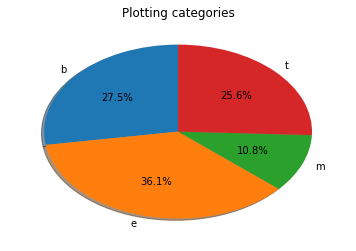

In [6]:
import pylab as pl # useful for drawing graphics

def categories_pie_plot(cont,tit):
    global labels
    sizes = [cont[l] for l in labels]
    pl.pie(sizes, explode=(0, 0, 0, 0), labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=90)
    pl.title(tit)
    pl.show()
    
categories_pie_plot(cont,"Plotting categories")

As we can see, the entertainment (e) category is the biggest one, which is more than three times bigger than health (m) category. In second place we have business (b) and technology (t), which are more than two times bigger than health category.

<h3>Splitting the data</h3>
Now we should split our data into two sets:

<p>1.a training set (70%) used to discover potentially predictive relationships, and</p>
2.a test set (30%) used to evaluate whether the discovered relationships hold and to assess the strength and utility of a predictive relationship.


Before splitting it, the data should be first permuted. Shuffle is a method included in scikit-learn library which allows to do random permutations of collections. Then data could be splitted into a pair of train and test sets.

In [7]:
from sklearn.utils import shuffle # Shuffle arrays in a consistent way

X_train = []
y_train = []
X_test = []
y_test = []

def split_data():
    global titles, categories
    global X_train, y_train, X_test, y_test,labels
    #titles corresponds to title of article.below we are finding total number of titles present sothat basedonthatwecandevidedata
    N = len(titles)
    Ntrain = int(N * 0.7)    
    # Let's shuffle the data
    titles, categories = shuffle(titles, categories, random_state=0)
    X_train = titles[:Ntrain]
    y_train = categories[:Ntrain]
    X_test = titles[Ntrain:]
    y_test = categories[Ntrain:]

In [8]:
%time split_data()

Wall time: 339 ms


Time required to split data is 1.28 seconds. Now let's analyze the proportion of news categories in the training set.

In [9]:
#here we are counting the articles as per their catagies from traing data
cont2 = count_data(labels,y_train)

  category    news   percent
0        b   81238  0.274738
1        e  106844  0.361334
2        m   31930  0.107984
3        t   75681  0.255945
total	 295693


Percentage are very much close to the ones obtained for the whole data set.

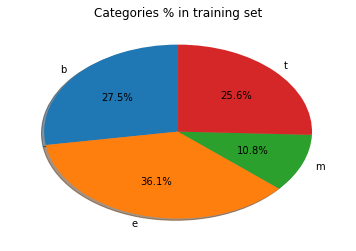

In [10]:
categories_pie_plot(cont2,"Categories % in training set")

<h3>Train and test the classifier</h3>
In order to train and test the classifier, the first step should be to tokenize and count the number of occurrence of each word that appears into the news'titles using for that CountVectorizer class. Each term found is assigned a unique integer index. Then the counters will be transformed to a TF-IDF representation using TfidfTransformer class. The last step creates the Multinomial Naive Bayes classifier. In order to make the training process easier, scikit-learn provides a Pipeline class that behaves like a compound classifier. The metrics module allows to calculate score functions, performance metrics and pairwise metrics and distance computations. F1-score can be interpreted as a weighted average of the precision and recall.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline 
from sklearn import metrics 
import numpy as np
import pprint

# lmats = [] # list of confussion matrix 
nrows = nlabels
ncols = nlabels
# conf_mat_sum = np.zeros((nrows, ncols))
# f1_acum = [] # list of f1-score

def train_test():
    global X_train, y_train, X_test, y_test, labels 
    #lmats, \
     #       conf_mat_sum, f1_acum, ncategories
    text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB()),
                         ])
    text_clf = text_clf.fit(X_train, y_train)
    predicted = text_clf.predict(X_test)
    return predicted

In [12]:
%time predicted = train_test()

Wall time: 16.7 s


To compare the predicted labels to the corresponding set of true labels we will use the method accuracy_score from scikit-learn, which gives an accuracy over 0.92

In [13]:
metrics.accuracy_score(y_test, predicted)

0.92380411281031516

To show the main classification metrics we will use the classification_report method from scikit-learn.

In [14]:
print(metrics.classification_report(y_test, predicted, target_names=labels))

             precision    recall  f1-score   support

          b       0.90      0.91      0.90     34729
          e       0.95      0.97      0.96     45625
          m       0.97      0.85      0.90     13709
          t       0.90      0.90      0.90     32663

avg / total       0.92      0.92      0.92    126726



We can see that, although the metrics (precision, recall and f1-score) in average give us 0.92, the results for category e (entertainment) are even better.

Confusion matrix allows to detect if a classification algorithm is confusing two or more classes if you have an unequal number of observations in each class as in this case. An ideal classifier with 100% accuracy would produce a pure diagonal matrix which would have all the points predicted in their correct class. In case of class imbalance, confusion matrix normalization by class support size (number of elements in each class) can be interesting in order to have a visual interpretation of which class is being misclassified.


In [15]:
mat = metrics.confusion_matrix(y_test, predicted,labels=labels)
cm = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
cm

array([[ 0.91004636,  0.02361139,  0.00552852,  0.06081373],
       [ 0.01176986,  0.97192329,  0.00192877,  0.01437808],
       [ 0.06200306,  0.06193012,  0.84601357,  0.03005325],
       [ 0.06778312,  0.02510486,  0.00324526,  0.90386676]])

Let's print a plot for the confussion matrix.

In [16]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:5.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.show()


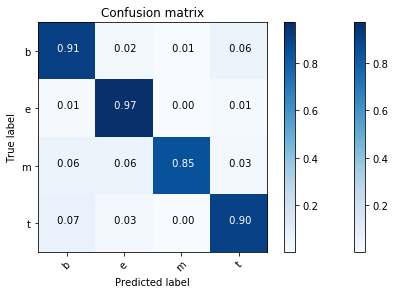

In [17]:
plot_confusion_matrix(cm, labels, title='Confusion matrix')

Confussion matrix columns represent the instances in a predicted class while rows represent the instances in an actual class. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

Now, let's see the relation between f1-score and the percentage by category

In [18]:
def resume_data(labels,y_train,f1s):
    c = Counter(y_train)
    cont = dict(c)
    tot = sum(list(cont.values()))
    nlabels = len(labels)
    d = {
        "category" : [labels[i] for i in range(nlabels)],
        "percent" : [cont[labels[i]]/tot for i in range(nlabels)],
        "f1-score" : [f1s[i] for i in range(nlabels)]
    }
   
    print(pd.DataFrame(d))   
    print("total \t",tot) 
    return cont

In [19]:
f1s = metrics.f1_score(y_test, predicted, labels=labels, average=None)
cont3 = resume_data(labels,y_train,f1s)

  category  f1-score   percent
0        b  0.903839  0.274738
1        e  0.959225  0.361334
2        m  0.902814  0.107984
3        t  0.903314  0.255945
total 	 295693


<h3>Logistic regression model</h3>

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

#Intiate the classifier
clf2=OneVsRestClassifier(LogisticRegression())

#fit the classifier to the training data 
#clf.fit(X_train,y_train)

#print accuracy
#print("Accuracy:{}".format(clf.score(X_test,y_test)))


text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', clf2),
                         ])
   
text_clf = text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)

metrics.accuracy_score(y_test, predicted)

0.94069093950728344

<h3>Results analysis</h3>


As a resume, results show a good accuracy (0.9238) with a good average level for precision, recall and f1-score (0.92) Analyzing these results by category, results are even better for the entertainment category ('e') with 0.96 for f1-score, 0.97 for recall and 0.95 for precision. I would like to highlight that best result for prediction corresponds to health category ('m') with 0.97, but with a recall of 0.85. Other categories show a more even behavior.
Analyzing confusion matrix results, the higher index of points predicted in their correct class for category 'e' with 0.9719. This category presents a misclassification index of 0.014 for technology category ('t') and lower indexes for the other categories. On the contrary, category 'm' presents the worst hit rate with an indicator of 0.846, which has misclassification indexes of 0.062 with business category ('b'), of 0.0619 with category 'e' and of 0.03 with category 't'. Analyzing the number of news by category, category 'e' presents the higher percentage, 36%, with 45625 news. On the other hand, category 'm' presents the lower percentage, 10.79%, with just 13709 news. Thus, category 'e' is more than three times bigger than category 'm'. Categories 'b' and 't' present similar number of news and percentage: 'b' has 34729 news with 27%, and 't' has 32663 news with a 25%. Both categories, 'b' and 't', are more than two times bigger than category 'm'. According to these, better results seem to correspond with higher percentage categories. In future experiments, I would try to confirm this hypothesis. In this experience, we just trained the classification algorithm with one set of data, so we just have one set of results. Although the training set and the test set were selected by random, it is just a sample of the possible results. In future experiments, I would try to test which is the confidence of the experiment results.